ResNet152_V2

In [4]:
import os
import json
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras

In [5]:
#This to allow reproducibilty
SEED = 1234
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [6]:
#Access to GoogleDrive and set dataframe directory
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
dataset_dir = "/content/drive/My Drive/DeepLearning/Image Classification/MaskDataset"

In [8]:
#Load dataset and "make" it categorical, and so following path data/training/class_1/img_1, img_2 ...
with open(os.path.join(dataset_dir,"train_gt.json")) as train_label:
    train_dict = json.load(train_label)

dataframe = pd.DataFrame(train_dict.items())
dataframe.rename(columns = {0:'filename', 1:'class'}, inplace = True)
dataframe["class"] = dataframe["class"].astype(str)                             #cast "class" to string
dataframe = dataframe.sample(frac=1).reset_index(drop=True)                     #shuffle dataframe (Keras performs it after splitting so having images ordered by class is ineffective)

In [9]:
#Data Augmentation performed on Training set
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import resnet_v2
from keras.applications.resnet_v2 import preprocess_input 
from keras.applications.resnet_v2 import ResNet152V2 

img_h = 408
img_w = 612
#This should allow us to make classes detailed with a description, but do no work :(
class_detailed = ['NO_PERSON', 
                  'ALL_PEOPLE', 
                  'SOMEONE']
training_dir = os.path.join(dataset_dir,'training')

#No zoom, rotating and anything that let image "lose information" since those transformations can modify image class
train_data_gen = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    validation_split=0.15,
                                    preprocessing_function = preprocess_input)

train_set_gen = train_data_gen.flow_from_dataframe(dataframe,
                                                   training_dir,
                                                   batch_size=16,
                                                   target_size=(img_w, img_h),
                                                   #classes=class_detailed,
                                                   class_mode='categorical',
                                                   subset='training',
                                                   shuffle=True,
                                                   seed=SEED)

#Operating in this way Augmentation is performed only on Training data (Validation set has fresh generator)
validation_data_gen = ImageDataGenerator(validation_split=0.15,
                                         preprocessing_function=preprocess_input)


valid_set_gen = validation_data_gen.flow_from_dataframe(dataframe,
                                                         training_dir,
                                                         batch_size=16,
                                                         target_size=(img_w, img_h),
                                                         #classes=class_detailed,
                                                         class_mode='categorical',  
                                                         subset='validation',
                                                         shuffle=True,
                                                         seed=SEED)


count = 0
for image in valid_set_gen.filenames:
  for image2 in train_set_gen.filenames:
    if(image == image2):
      count+=1
print("Common image among sets: " + str(count))         #checking for disjointness of validation and training set

count_0 = 0
count_1 = 0
count_2 = 0
for classes in valid_set_gen.classes:
  if classes == 0:
    count_0 += 1
  if classes == 1:
    count_1 += 1
  if classes == 2:
    count_2 += 1
print("Image of class 0 #" + str(count_0))
print("Image of class 1 #" + str(count_1))
print("Image of class 2 #" + str(count_2))               #checking image distribution w.r.t classes among validation set 

Found 4772 validated image filenames belonging to 3 classes.
Found 842 validated image filenames belonging to 3 classes.
Common image among sets: 0
Image of class 0 #290
Image of class 1 #277
Image of class 2 #275


In [10]:
#Now let's shape train, validation set.
num_classes = 3

#TRAINING
training_set = tf.data.Dataset.from_generator(lambda: train_set_gen,
                                              output_types=(tf.float32, tf.float32),
                                              output_shapes=([None, img_w,img_h,3], [None, num_classes]))
training_set = training_set.repeat()

#VALIDATION
validation_set = tf.data.Dataset.from_generator(lambda: valid_set_gen,
                                                output_types=(tf.float32, tf.float32),
                                                output_shapes=([None, img_w,img_h,3], [None, num_classes]))
validation_set = validation_set.repeat()

[]

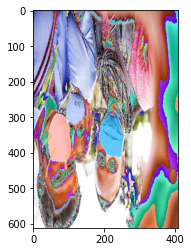

In [11]:
#This allow us to see the images fed to our NN
import matplotlib.pyplot as plt
%matplotlib inline

iterator = iter(training_set)
augmented_img, target = next(iterator)

augmented_img = np.array(augmented_img[0])
augmented_img = augmented_img * 255

plt.imshow(np.uint8(augmented_img))
plt.plot()

In [12]:
# Load VGG19

pre_trained_model = ResNet152V2(input_shape=(img_w,img_h,3), pooling='avg', include_top=False, weights="imagenet")

234553344/234545216 [==============================] - 4s 0us/step


In [13]:
pre_trained_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 612, 408, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 618, 414, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 306, 204, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 308, 206, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [14]:
# Create CNN model
finetuning = True

if finetuning:
    freeze_until = 23 # layer from which we want to fine-tune
    
    for layer in pre_trained_model.layers[:freeze_until]:
        layer.trainable = False
else:
    pre_trained_model.trainable = False

#Add CNN to model
model = tf.keras.Sequential()
model.add(pre_trained_model)

#Add FCNN part (CNN top)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=256, activation='relu',kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5)))
model.add(tf.keras.layers.Dropout(rate=0.6))
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 2048)              58331648  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 58,856,963
Trainable params: 58,612,099
Non-trainable params: 244,864
_________________________________________________________________


In [16]:
loss = tf.keras.losses.CategoricalCrossentropy()
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [17]:
callbacks = []

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
callbacks.append(es_callback)

In [18]:
history = model.fit(x=training_set,
                    epochs=100,
                    steps_per_epoch=len(train_set_gen),
                    validation_data=validation_set,
                    validation_steps=len(valid_set_gen),
                    callbacks=callbacks)

Epoch 1/100
299/299 [==============================] - 1927s 6s/step - loss: 0.6817 - accuracy: 0.7659 - val_loss: 0.6655 - val_accuracy: 0.7399
Epoch 2/100
299/299 [==============================] - 618s 2s/step - loss: 0.4760 - accuracy: 0.8778 - val_loss: 0.5419 - val_accuracy: 0.8432
Epoch 3/100
299/299 [==============================] - 615s 2s/step - loss: 0.4144 - accuracy: 0.9082 - val_loss: 0.4381 - val_accuracy: 0.8812
Epoch 4/100
299/299 [==============================] - 615s 2s/step - loss: 0.3520 - accuracy: 0.9279 - val_loss: 0.4067 - val_accuracy: 0.9181
Epoch 5/100
299/299 [==============================] - 615s 2s/step - loss: 0.3489 - accuracy: 0.9308 - val_loss: 0.4275 - val_accuracy: 0.8860
Epoch 6/100
299/299 [==============================] - 615s 2s/step - loss: 0.3163 - accuracy: 0.9371 - val_loss: 0.3439 - val_accuracy: 0.9204
Epoch 7/100
299/299 [==============================] - 616s 2s/step - loss: 0.2863 - accuracy: 0.9510 - val_loss: 0.3696 - val_accuracy

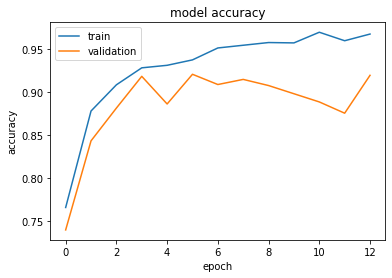

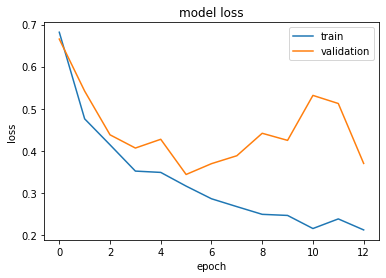

In [19]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [20]:
import os
from datetime import datetime

def create_csv(results, results_dir):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [22]:
from PIL import Image

dataset_dir_test = os.path.join(dataset_dir,"test") #Path di questo tipo /content/drive/My Drive/DeepLearning/Image Classification/MaskDataset/test
image_filenames = next(os.walk(dataset_dir_test))[2]

results = {}
for image_name in image_filenames:

  img = Image.open(os.path.join(dataset_dir_test, image_name)).convert('RGB')
  img = img.resize((img_h, img_w))
  img_array = np.array(img)
  img_array = np.expand_dims(img_array, 0) 
  img_array = preprocess_input(img_array)

  prediction = model.predict(img_array)
  results[image_name] = np.argmax(np.matrix(prediction))

create_csv(results, os.path.join(dataset_dir,"Results/Comune"))